PART - A

1. Initialize Network
2. Forward Propagation
3. Compute Loss
4. Backpropagation
5. Update Parameters
6. Training Loop
7. Model Evaluation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import seaborn as sns

class FFNN:
    def __init__(self, layer_sizes, activations):
        """
        Initialize the neural network
        layer_sizes: list of integers representing neurons in each layer
        activations: list of activation functions for each layer
        """
        if len(layer_sizes) != len(activations) + 1:
            raise ValueError("Number of activation functions must be equal to number of layers - 1")

        self.layer_sizes = layer_sizes
        self.activations = activations
        self.parameters = self.initialize_parameters()

    def initialize_parameters(self):
        """
        Initialize weights and biases
        Returns: dictionary containing parameters
        """
        parameters = {}
        L = len(self.layer_sizes)

        for l in range(1, L):
            parameters[f'W{l}'] = np.random.randn(self.layer_sizes[l],
                self.layer_sizes[l-1]) * np.sqrt(2.0 / self.layer_sizes[l-1])  # He initialization
            parameters[f'b{l}'] = np.zeros((self.layer_sizes[l], 1))

        return parameters

    def sigmoid(self, Z):
        """Sigmoid activation function"""
        A = 1 / (1 + np.exp(-Z))
        return A, Z

    def relu(self, Z):
        """ReLU activation function"""
        A = np.maximum(0, Z)
        return A, Z

    def tanh(self, Z):
        """Tanh activation function"""
        A = np.tanh(Z)
        return A, Z

    def softmax(self, Z):
        """Softmax activation function"""
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        return A, Z

    def forward_propagation(self, X):
        """
        Forward propagation step
        X: input data
        Returns: output probabilities and cache of intermediate values
        """
        caches = []
        A = X
        L = len(self.parameters) // 2

        for l in range(1, L+1):
            A_prev = A
            W = self.parameters[f'W{l}']
            b = self.parameters[f'b{l}']
            Z = np.dot(W, A_prev) + b

            if l == L:  # Output layer
                A, _ = self.softmax(Z)
            else:  # Hidden layers
                if self.activations[l-1] == "sigmoid":
                    A, _ = self.sigmoid(Z)
                elif self.activations[l-1] == "relu":
                    A, _ = self.relu(Z)
                elif self.activations[l-1] == "tanh":
                    A, _ = self.tanh(Z)

            cache = (A_prev, W, b, Z, A)
            caches.append(cache)

        return A, caches

    def compute_loss(self, Y, A):
        """
        Compute cross-entropy loss
        Y: true labels (one-hot encoded)
        A: predicted probabilities
        """
        m = Y.shape[1]
        epsilon = 1e-15
        A = np.clip(A, epsilon, 1 - epsilon)
        return -np.sum(Y * np.log(A)) / m

    def backward_propagation(self, X, Y, caches):
        """
        Backward propagation step
        Returns: gradients
        """
        grads = {}
        L = len(caches)
        m = Y.shape[1]

        # Output layer
        current_cache = caches[L-1]
        A_prev, W, b, Z, A = current_cache
        dZ = A - Y

        grads[f'dW{L}'] = np.dot(dZ, A_prev.T) / m
        grads[f'db{L}'] = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)

        # Hidden layers
        for l in reversed(range(L-1)):
            current_cache = caches[l]
            A_prev, W, b, Z, A = current_cache

            if self.activations[l] == "sigmoid":
                dZ = dA_prev * A * (1 - A)
            elif self.activations[l] == "relu":
                dZ = dA_prev * (Z > 0)
            elif self.activations[l] == "tanh":
                dZ = dA_prev * (1 - np.power(A, 2))

            grads[f'dW{l+1}'] = np.dot(dZ, A_prev.T) / m
            grads[f'db{l+1}'] = np.sum(dZ, axis=1, keepdims=True) / m
            if l > 0:
                dA_prev = np.dot(W.T, dZ)

        return grads

    def update_parameters(self, grads, learning_rate):
        """
        Update network parameters using gradient descent
        """
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters[f'W{l+1}'] -= learning_rate * grads[f'dW{l+1}']
            self.parameters[f'b{l+1}'] -= learning_rate * grads[f'db{l+1}']

    def compute_accuracy(self, Y, A):
        """Calculate prediction accuracy"""
        predictions = np.argmax(A, axis=0)
        true_labels = np.argmax(Y, axis=0)
        return np.mean(predictions == true_labels)

    def train(self, X_train, Y_train, X_test, Y_test, learning_rate, num_epochs, batch_size=32):
        """
        Train the neural network
        Returns: history of loss and accuracy values
        """
        history = {
            'train_loss': [],
            'train_acc': [],
            'test_acc': []
        }

        m = X_train.shape[1]
        n_batches = m // batch_size

        for epoch in range(num_epochs):
            epoch_loss = 0

            # Shuffle the data
            permutation = np.random.permutation(m)
            X_shuffled = X_train[:, permutation]
            Y_shuffled = Y_train[:, permutation]

            for i in range(n_batches):
                # Get mini-batch
                start_idx = i * batch_size
                end_idx = start_idx + batch_size
                X_batch = X_shuffled[:, start_idx:end_idx]
                Y_batch = Y_shuffled[:, start_idx:end_idx]

                # Forward propagation
                A, caches = self.forward_propagation(X_batch)

                # Compute loss
                loss = self.compute_loss(Y_batch, A)
                epoch_loss += loss

                # Backward propagation
                grads = self.backward_propagation(X_batch, Y_batch, caches)

                # Update parameters
                self.update_parameters(grads, learning_rate)

            # Calculate epoch metrics
            A_train, _ = self.forward_propagation(X_train)
            train_acc = self.compute_accuracy(Y_train, A_train)

            A_test, _ = self.forward_propagation(X_test)
            test_acc = self.compute_accuracy(Y_test, A_test)

            # Store metrics
            history['train_loss'].append(epoch_loss / n_batches)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)

            if epoch % 5 == 0:
                print(f"Epoch {epoch}: Loss = {epoch_loss/n_batches:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

        return history

def load_mnist_data():
    """Load and preprocess MNIST dataset"""
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    # Reshape and normalize
    X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0

    # One-hot encode labels
    Y_train = np.eye(10)[y_train].T
    Y_test = np.eye(10)[y_test].T

    return X_train, Y_train, X_test, Y_test

def plot_training_history(history):
    """Plot training metrics"""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['test_acc'], label='Test')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 0: Loss = 0.5488, Train Acc = 0.9091, Test Acc = 0.9124
Epoch 5: Loss = 0.1542, Train Acc = 0.9589, Test Acc = 0.9542
Epoch 10: Loss = 0.0996, Train Acc = 0.9728, Test Acc = 0.9667
Epoch 15: Loss = 0.0719, Train Acc = 0.9810, Test Acc = 0.9710
Epoch 20: Loss = 0.0547, Train Acc = 0.9864, Test Acc = 0.9741
Epoch 25: Loss = 0.0426, Train Acc = 0.9902, Test Acc = 0.9751
Epoch 30: Loss = 0.0331, Train Acc = 0.9928, Test Acc = 0.9757
Epoch 35: Loss = 0.0260, Train Acc = 0.9948, Test Acc = 0.9757
Epoch 40: Loss = 0.0209, Train Acc = 0.9959, Test Acc = 0.9772
Epoch 45: Loss = 0.0168, Train Acc = 0.9979, Test Acc = 0.9775


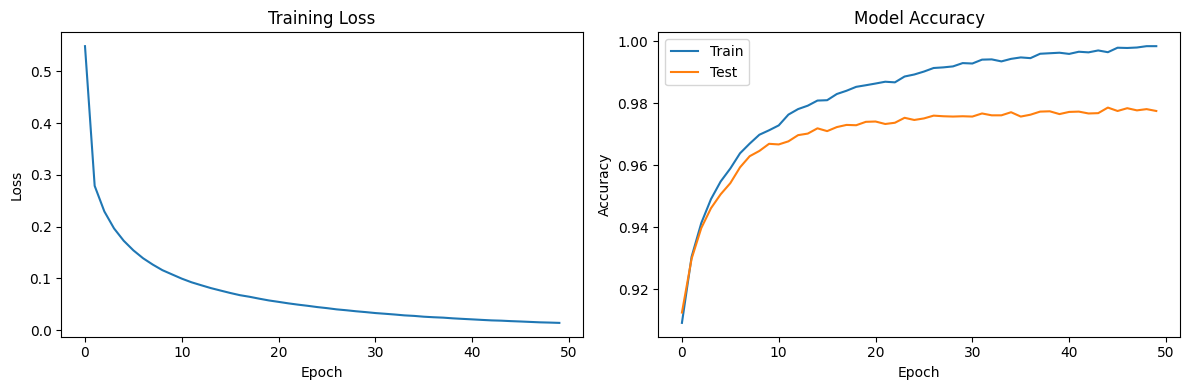

In [ ]:
# Load and prepare MNIST data
X_train, Y_train, X_test, Y_test = load_mnist_data()

# Create network with proper dimensions
layer_sizes = [784, 128, 64, 10]  # Must end with 10 for MNIST's 10 classes
activations = ["relu", "relu", "softmax"]  # One activation per layer except input

# Create and train the model
model = FFNN(layer_sizes, activations)
history = model.train(
    X_train, Y_train,
    X_test, Y_test,
    learning_rate=0.01,
    num_epochs=50,
    batch_size=32
)

# Plot training history
plot_training_history(history)

Part B Task 1 Activation function Analysis


In [ ]:
# Part 2 - Task 1: Activation Function Analysis
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # For progress bars

class ActivationAnalyzer:
    def __init__(self, input_dim=784, output_dim=10):
        """
        Initialize analyzer for 5-layer FFNN with different activation functions
        """
        self.layer_sizes = [input_dim, 256, 128, 64, 32, output_dim]
        self.activation_types = ["sigmoid", "relu", "tanh"]
        self.activation_values = {}  # Store activation values for analysis

    def create_5layer_network(self, activation_type):
        """
        Create 5-layer FFNN with specified activation
        """
        # All hidden layers use the specified activation, output layer uses softmax
        activations = [activation_type] * 4 + ["softmax"]
        return FFNN(self.layer_sizes, activations)

    def collect_activations(self, model, X):
        """
        Collect activation values from all layers
        """
        A, caches = model.forward_propagation(X)
        activations = []

        for cache in caches[:-1]:  # Exclude output layer
            _, _, _, _, A = cache
            activations.append(A.flatten())

        return activations

    def plot_activation_distributions(self, activation_values, activation_type):
        """
        Plot histograms of activation values for each layer
        """
        plt.figure(figsize=(15, 10))
        for i, values in enumerate(activation_values):
            plt.subplot(2, 2, i+1)
            sns.histplot(values, bins=50)
            plt.title(f'Layer {i+1} Activation Distribution\n{activation_type}')
            plt.xlabel('Activation Value')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

    def plot_comparison_curves(self, histories):
        """
        Plot loss and accuracy curves for different activation functions
        """
        plt.figure(figsize=(15, 5))

        # Loss curves
        plt.subplot(1, 2, 1)
        for act_type, history in histories.items():
            plt.plot(history['train_loss'], label=act_type)
        plt.title('Training Loss Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy curves
        plt.subplot(1, 2, 2)
        for act_type, history in histories.items():
            plt.plot(history['test_acc'], label=act_type)
        plt.title('Test Accuracy Comparison')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_final_accuracy_comparison(self, histories):
        """
        Bar plot of final accuracy for each activation function
        """
        final_accuracies = {act: hist['test_acc'][-1]
                           for act, hist in histories.items()}

        plt.figure(figsize=(10, 5))
        plt.bar(final_accuracies.keys(), final_accuracies.values())
        plt.title('Final Test Accuracy by Activation Function')
        plt.xlabel('Activation Function')
        plt.ylabel('Accuracy')
        for i, v in enumerate(final_accuracies.values()):
            plt.text(i, v, f'{v:.3f}', ha='center')
        plt.show()

    def analyze_activations(self, X_train, Y_train, X_test, Y_test):
        """
        Run complete activation function analysis
        """
        print("Starting activation function analysis...")
        histories = {}

        for act_type in self.activation_types:
            print(f"\nTraining network with {act_type} activation...")

            # Create and train network
            model = self.create_5layer_network(act_type)
            history = model.train(
                X_train, Y_train,
                X_test, Y_test,
                learning_rate=0.01,
                num_epochs=30,
                batch_size=64
            )
            histories[act_type] = history

            # Collect and plot activation distributions
            print(f"\nAnalyzing {act_type} activation distributions...")
            activation_values = self.collect_activations(model, X_test[:, :100])
            self.plot_activation_distributions(activation_values, act_type)

        # Plot comparative analysis
        print("\nGenerating comparative analysis plots...")
        self.plot_comparison_curves(histories)
        self.plot_final_accuracy_comparison(histories)

        return histories

# Function to run Task 1 analysis
def run_activation_analysis(X_train, Y_train, X_test, Y_test):
    """
    Run complete analysis for Task 1
    """
    print("Part 2 - Task 1: Activation Function Analysis")
    print("=" * 50)

    analyzer = ActivationAnalyzer()
    histories = analyzer.analyze_activations(X_train, Y_train, X_test, Y_test)

    # Print summary findings
    print("\nSummary Findings:")
    print("-" * 20)
    for act_type, history in histories.items():
        final_acc = history['test_acc'][-1]
        final_loss = history['train_loss'][-1]
        print(f"{act_type}:")
        print(f"  Final Test Accuracy: {final_acc:.4f}")
        print(f"  Final Training Loss: {final_loss:.4f}")

Part B Task 2: Batch Normalization Analysis

In [ ]:
# Part 2 - Task 2: Batch Normalization Analysis
class BatchNormLayer:
    def __init__(self, num_features):
        self.gamma = np.ones((num_features, 1))
        self.beta = np.zeros((num_features, 1))
        self.epsilon = 1e-8

        # Running estimates
        self.running_mean = np.zeros((num_features, 1))
        self.running_var = np.ones((num_features, 1))

    def forward(self, X, training=True):
        if training:
            mean = np.mean(X, axis=1, keepdims=True)
            var = np.var(X, axis=1, keepdims=True)

            # Update running estimates
            self.running_mean = 0.9 * self.running_mean + 0.1 * mean
            self.running_var = 0.9 * self.running_var + 0.1 * var
        else:
            mean = self.running_mean
            var = self.running_var

        X_norm = (X - mean) / np.sqrt(var + self.epsilon)
        out = self.gamma * X_norm + self.beta

        if training:
            self.cache = (X, X_norm, mean, var)

        return out

    def backward(self, dout):
        X, X_norm, mean, var = self.cache
        m = X.shape[1]

        dX_norm = dout * self.gamma
        dvar = np.sum(dX_norm * (X - mean) * -0.5 * (var + self.epsilon)**(-1.5), axis=1, keepdims=True)
        dmean = np.sum(dX_norm * -1/np.sqrt(var + self.epsilon), axis=1, keepdims=True)

        dX = (dX_norm / np.sqrt(var + self.epsilon) +
              2 * dvar * (X - mean) / m +
              dmean / m)

        self.dgamma = np.sum(dout * X_norm, axis=1, keepdims=True)
        self.dbeta = np.sum(dout, axis=1, keepdims=True)

        return dX

class BatchNormAnalyzer:
    def __init__(self):
        self.layer_sizes = [784, 256, 128, 64, 32, 10]

    def create_networks(self):
        """Create networks with and without batch normalization"""
        # Standard network
        standard_net = FFNN(self.layer_sizes, ["relu"]*4 + ["softmax"])

        # Network with batch norm
        bn_net = FFNN(self.layer_sizes, ["relu"]*4 + ["softmax"])
        bn_net.batch_norm_layers = [BatchNormLayer(size) for size in self.layer_sizes[1:-1]]

        return standard_net, bn_net

    def plot_activation_distributions(self, standard_acts, bn_acts):
        """Plot activation distributions with and without batch norm"""
        plt.figure(figsize=(15, 10))
        for i in range(4):  # For each hidden layer
            plt.subplot(2, 2, i+1)
            sns.histplot(standard_acts[i], alpha=0.5, label='Standard', bins=50)
            sns.histplot(bn_acts[i], alpha=0.5, label='BatchNorm', bins=50)
            plt.title(f'Layer {i+1} Activation Distribution')
            plt.xlabel('Activation Value')
            plt.ylabel('Frequency')
            plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_gradient_flow(self, standard_grads, bn_grads):
        """Plot gradient magnitudes across layers"""
        plt.figure(figsize=(10, 6))
        layers = range(1, len(self.layer_sizes))
        plt.plot(layers, standard_grads, 'o-', label='Standard')
        plt.plot(layers, bn_grads, 'o-', label='BatchNorm')
        plt.title('Gradient Magnitude Across Layers')
        plt.xlabel('Layer')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_convergence_comparison(self, standard_history, bn_history):
        """Plot training curves for comparison"""
        plt.figure(figsize=(15, 5))

        # Loss comparison
        plt.subplot(1, 2, 1)
        plt.plot(standard_history['train_loss'], label='Standard')
        plt.plot(bn_history['train_loss'], label='BatchNorm')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy comparison
        plt.subplot(1, 2, 2)
        plt.plot(standard_history['test_acc'], label='Standard')
        plt.plot(bn_history['test_acc'], label='BatchNorm')
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

def run_batchnorm_analysis(X_train, Y_train, X_test, Y_test):
    """Run complete analysis for Task 2"""
    print("Part 2 - Task 2: Batch Normalization Analysis")
    print("=" * 50)

    analyzer = BatchNormAnalyzer()
    standard_net, bn_net = analyzer.create_networks()

    # Train both networks
    print("\nTraining standard network...")
    standard_history = standard_net.train(X_train, Y_train, X_test, Y_test,
                                        learning_rate=0.01, num_epochs=30)

    print("\nTraining network with batch normalization...")
    bn_history = bn_net.train(X_train, Y_train, X_test, Y_test,
                             learning_rate=0.01, num_epochs=30)

    # Collect and analyze activations
    standard_acts = standard_net.collect_activations(X_test[:, :100])
    bn_acts = bn_net.collect_activations(X_test[:, :100])
    analyzer.plot_activation_distributions(standard_acts, bn_acts)

    # Analyze gradient flow
    standard_grads = [np.mean(np.abs(g)) for g in standard_net.compute_gradients()]
    bn_grads = [np.mean(np.abs(g)) for g in bn_net.compute_gradients()]
    analyzer.plot_gradient_flow(standard_grads, bn_grads)

    # Compare convergence
    analyzer.plot_convergence_comparison(standard_history, bn_history)

Part B Task 3: Network Depth Analysis

In [ ]:
# Part 2 - Task 3: Network Depth Analysis
class NetworkDepthAnalyzer:
    def __init__(self, input_dim=784, output_dim=10):
        """
        Analyzer for networks of different depths
        depths: [3, 5, 7, 10] layers as specified in assignment
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.depths = [3, 5, 7, 10]

    def create_network_architecture(self, depth):
        """
        Create layer sizes for network of specified depth
        """
        if depth < 3:
            raise ValueError("Depth must be at least 3 (input, hidden, output)")

        # Start with input and end with output
        layer_sizes = [self.input_dim]

        # Add hidden layers with gradually decreasing size
        hidden_layers = depth - 2
        start_size = 512
        for i in range(hidden_layers):
            layer_size = max(32, start_size // (2**i))  # Don't go below 32 neurons
            layer_sizes.append(layer_size)

        # Add output layer
        layer_sizes.append(self.output_dim)

        return layer_sizes

    def plot_activation_distributions(self, activations_dict):
        """
        Plot activation distributions for different network depths
        """
        plt.figure(figsize=(20, 15))
        for i, (depth, activations) in enumerate(activations_dict.items()):
            plt.subplot(2, 2, i+1)
            for j, layer_activations in enumerate(activations[1:-1]):  # Skip input and output
                sns.kdeplot(layer_activations.flatten(), label=f'Layer {j+1}')
            plt.title(f'{depth}-Layer Network Activations')
            plt.xlabel('Activation Value')
            plt.ylabel('Density')
            plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_gradient_flow(self, gradient_dict):
        """
        Plot gradient magnitudes across layers for different depths
        """
        plt.figure(figsize=(12, 6))
        for depth, gradients in gradient_dict.items():
            layers = range(1, len(gradients) + 1)
            plt.plot(layers, gradients, 'o-', label=f'{depth} layers')
        plt.title('Gradient Magnitude Across Layers')
        plt.xlabel('Layer')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_convergence_comparison(self, histories):
        """
        Plot training curves for different network depths
        """
        plt.figure(figsize=(15, 5))

        # Loss comparison
        plt.subplot(1, 2, 1)
        for depth, history in histories.items():
            plt.plot(history['train_loss'], label=f'{depth} layers')
        plt.title('Training Loss by Network Depth')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy comparison
        plt.subplot(1, 2, 2)
        for depth, history in histories.items():
            plt.plot(history['test_acc'], label=f'{depth} layers')
        plt.title('Test Accuracy by Network Depth')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_final_metrics(self, histories):
        """
        Plot final accuracy and convergence time for different depths
        """
        depths = list(histories.keys())
        accuracies = [hist['test_acc'][-1] for hist in histories.values()]

        # Calculate epochs to reach 95% of final accuracy
        convergence_epochs = []
        for hist in histories.values():
            final_acc = hist['test_acc'][-1]
            threshold = 0.95 * final_acc
            epochs_to_converge = next(
                (i for i, acc in enumerate(hist['test_acc']) if acc >= threshold),
                len(hist['test_acc'])
            )
            convergence_epochs.append(epochs_to_converge)

        # Plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Accuracy plot
        ax1.plot(depths, accuracies, 'o-')
        ax1.set_title('Final Test Accuracy vs Network Depth')
        ax1.set_xlabel('Number of Layers')
        ax1.set_ylabel('Test Accuracy')
        ax1.grid(True)

        # Convergence time plot
        ax2.plot(depths, convergence_epochs, 'o-')
        ax2.set_title('Convergence Speed vs Network Depth')
        ax2.set_xlabel('Number of Layers')
        ax2.set_ylabel('Epochs to 95% Final Accuracy')
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

def run_depth_analysis(X_train, Y_train, X_test, Y_test):
    """
    Run complete analysis for Task 3
    """
    print("Part 2 - Task 3: Network Depth Analysis")
    print("=" * 50)

    analyzer = NetworkDepthAnalyzer()
    histories = {}
    activations_dict = {}
    gradient_dict = {}

    for depth in analyzer.depths:
        print(f"\nTraining {depth}-layer network...")

        # Create and train network
        layer_sizes = analyzer.create_network_architecture(depth)
        activations = ["relu"] * (depth-2) + ["softmax"]
        model = FFNN(layer_sizes, activations)

        history = model.train(
            X_train, Y_train,
            X_test, Y_test,
            learning_rate=0.01,
            num_epochs=30,
            batch_size=64
        )

        histories[depth] = history

        # Collect activations and gradients
        print(f"Analyzing {depth}-layer network...")
        A, caches = model.forward_propagation(X_test[:, :100])
        activations_dict[depth] = [cache[4] for cache in caches]  # Get activation values

        grads = model.backward_propagation(X_test[:, :100], Y_test[:, :100], caches)
        gradient_dict[depth] = [np.mean(np.abs(g)) for g in grads.values()]

    # Generate plots
    print("\nGenerating analysis plots...")
    analyzer.plot_activation_distributions(activations_dict)
    analyzer.plot_gradient_flow(gradient_dict)
    analyzer.plot_convergence_comparison(histories)
    analyzer.plot_final_metrics(histories)

    # Print summary findings
    print("\nSummary Findings:")
    print("-" * 20)
    for depth, history in histories.items():
        final_acc = history['test_acc'][-1]
        print(f"{depth}-layer network:")
        print(f"  Final Test Accuracy: {final_acc:.4f}")

Part B Task 4: Weight Initialization Analysis

In [ ]:
# Part 2 - Task 4: Weight Initialization Analysis
class WeightInitializer:
    @staticmethod
    def random_init(prev_layer_size, current_layer_size):
        """Random initialization with small values"""
        return np.random.randn(current_layer_size, prev_layer_size) * 0.01

    @staticmethod
    def xavier_init(prev_layer_size, current_layer_size):
        """Xavier/Glorot initialization"""
        limit = np.sqrt(6 / (prev_layer_size + current_layer_size))
        return np.random.uniform(-limit, limit, (current_layer_size, prev_layer_size))

    @staticmethod
    def he_init(prev_layer_size, current_layer_size):
        """He initialization"""
        return np.random.randn(current_layer_size, prev_layer_size) * np.sqrt(2 / prev_layer_size)

class InitializationAnalyzer:
    def __init__(self, input_dim=784, output_dim=10):
        """
        Analyzer for different weight initialization methods
        """
        self.layer_sizes = [input_dim, 256, 128, 64, output_dim]
        self.init_methods = {
            "Random": WeightInitializer.random_init,
            "Xavier": WeightInitializer.xavier_init,
            "He": WeightInitializer.he_init
        }

    def create_network(self, init_method):
        """
        Create network with specified initialization method
        """
        model = FFNN(self.layer_sizes, ["relu"]*3 + ["softmax"])

        # Override default initialization
        L = len(self.layer_sizes)
        for l in range(1, L):
            model.parameters[f'W{l}'] = init_method(
                self.layer_sizes[l-1],
                self.layer_sizes[l]
            )

        return model

    def plot_initial_weight_distributions(self, models):
        """
        Plot weight distributions after initialization
        """
        plt.figure(figsize=(15, 10))
        for i, (name, model) in enumerate(models.items(), 1):
            plt.subplot(2, 2, i)
            for l in range(1, len(self.layer_sizes)):
                weights = model.parameters[f'W{l}'].flatten()
                sns.histplot(weights, label=f'Layer {l}', bins=50)
            plt.title(f'{name} Initialization')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_activation_distributions(self, activation_dict):
        """
        Plot activation distributions for different initialization methods
        """
        plt.figure(figsize=(15, 10))
        for i, (name, activations) in enumerate(activation_dict.items(), 1):
            plt.subplot(2, 2, i)
            for j, layer_activations in enumerate(activations[:-1]):  # Exclude output
                sns.kdeplot(layer_activations.flatten(), label=f'Layer {j+1}')
            plt.title(f'{name} Initialization - Activations')
            plt.xlabel('Activation Value')
            plt.ylabel('Density')
            plt.legend()
        plt.tight_layout()
        plt.show()

    def plot_gradient_flow(self, gradient_dict):
        """
        Plot gradient magnitudes across layers
        """
        plt.figure(figsize=(10, 6))
        for name, gradients in gradient_dict.items():
            layers = range(1, len(gradients) + 1)
            plt.plot(layers, gradients, 'o-', label=name)
        plt.title('Gradient Magnitude Across Layers')
        plt.xlabel('Layer')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_training_comparison(self, histories):
        """
        Plot training curves for different initialization methods
        """
        plt.figure(figsize=(15, 5))

        # Loss comparison
        plt.subplot(1, 2, 1)
        for name, history in histories.items():
            plt.plot(history['train_loss'], label=name)
        plt.title('Training Loss by Initialization Method')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Accuracy comparison
        plt.subplot(1, 2, 2)
        for name, history in histories.items():
            plt.plot(history['test_acc'], label=name)
        plt.title('Test Accuracy by Initialization Method')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

def run_initialization_analysis(X_train, Y_train, X_test, Y_test):
    """
    Run complete analysis for Task 4
    """
    print("Part 2 - Task 4: Weight Initialization Analysis")
    print("=" * 50)

    analyzer = InitializationAnalyzer()
    models = {}
    histories = {}
    activation_dict = {}
    gradient_dict = {}

    # Create and initialize models
    for name, init_method in analyzer.init_methods.items():
        models[name] = analyzer.create_network(init_method)

    # Plot initial weight distributions
    print("\nAnalyzing initial weight distributions...")
    analyzer.plot_initial_weight_distributions(models)

    # Train models and collect data
    for name, model in models.items():
        print(f"\nTraining model with {name} initialization...")
        history = model.train(
            X_train, Y_train,
            X_test, Y_test,
            learning_rate=0.01,
            num_epochs=30,
            batch_size=64
        )
        histories[name] = history

        # Collect activations and gradients
        A, caches = model.forward_propagation(X_test[:, :100])
        activation_dict[name] = [cache[4] for cache in caches]

        grads = model.backward_propagation(X_test[:, :100], Y_test[:, :100], caches)
        gradient_dict[name] = [np.mean(np.abs(g)) for g in grads.values()]

    # Generate analysis plots
    print("\nGenerating analysis plots...")
    analyzer.plot_activation_distributions(activation_dict)
    analyzer.plot_gradient_flow(gradient_dict)
    analyzer.plot_training_comparison(histories)

    # Print summary findings
    print("\nSummary Findings:")
    print("-" * 20)
    for name, history in histories.items():
        final_acc = history['test_acc'][-1]
        print(f"{name} initialization:")
        print(f"  Final Test Accuracy: {final_acc:.4f}")